## First training and testing on ESC-50

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

# Import self-implemented torch dataset
from datasets import ESCDataset

In [2]:
train_data = ESCDataset(root='ESC-50-master', 
                        esc50=True, 
                        val_fold=4,
                        train=True,
                        download=True)
valid_data = ESCDataset(root='ESC-50-master', 
                        esc50=True, 
                        val_fold=4,
                        train=False,
                        download=False)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

print('train data length', len(train_data))
print('valid data length', len(valid_data))

Download not needed, files already on disk.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:16<00:00, 24.24it/s]

train data length 1600
valid data length 400


In [3]:
from torchvision.models import resnet34
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
  
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512, train_data.num_classes)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

/home/xiaofan/anaconda3/envs/esc50-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xiaofan/anaconda3/envs/esc50-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [5]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 25
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

  0%|                                                                                                                                                                                 | 0/25 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 2.4930791628360747


  4%|██████▊                                                                                                                                                                  | 1/25 [00:03<01:17,  3.22s/it]

Epoch - 1 Valid-Loss : 1.6604513025283814 Valid-Accuracy : 0.485
Epoch - 2 Train-Loss : 1.2042074602842332


  8%|█████████████▌                                                                                                                                                           | 2/25 [00:06<01:09,  3.00s/it]

Epoch - 2 Valid-Loss : 1.3291405320167542 Valid-Accuracy : 0.6125


 12%|████████████████████▎                                                                                                                                                    | 3/25 [00:08<01:04,  2.93s/it]

Epoch - 3 Train-Loss : 0.765508099347353
Epoch - 3 Valid-Loss : 0.8611168193817139 Valid-Accuracy : 0.73
Epoch - 4 Train-Loss : 0.5321586972475052


 16%|███████████████████████████                                                                                                                                              | 4/25 [00:11<01:00,  2.90s/it]

Epoch - 4 Valid-Loss : 0.9246294069290161 Valid-Accuracy : 0.7525
Epoch - 5 Train-Loss : 0.3809169688075781


 20%|█████████████████████████████████▊                                                                                                                                       | 5/25 [00:14<00:57,  2.89s/it]

Epoch - 5 Valid-Loss : 0.854361937046051 Valid-Accuracy : 0.7475
Epoch - 6 Train-Loss : 0.3112839213758707


 24%|████████████████████████████████████████▌                                                                                                                                | 6/25 [00:17<00:54,  2.88s/it]

Epoch - 6 Valid-Loss : 0.9720241641998291 Valid-Accuracy : 0.7375
Epoch - 7 Train-Loss : 0.24571499187499285


 28%|███████████████████████████████████████████████▎                                                                                                                         | 7/25 [00:20<00:51,  2.88s/it]

Epoch - 7 Valid-Loss : 0.8948402726650238 Valid-Accuracy : 0.755
Epoch - 8 Train-Loss : 0.23946623904630543


 32%|██████████████████████████████████████████████████████                                                                                                                   | 8/25 [00:23<00:48,  2.87s/it]

Epoch - 8 Valid-Loss : 0.7681429290771484 Valid-Accuracy : 0.785
Epoch - 9 Train-Loss : 0.11687582693994045


 36%|████████████████████████████████████████████████████████████▊                                                                                                            | 9/25 [00:26<00:45,  2.87s/it]

Epoch - 9 Valid-Loss : 0.5907814314961434 Valid-Accuracy : 0.815
Changed learning rate to 2e-05
Epoch - 10 Train-Loss : 0.0660281778872013


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 10/25 [00:28<00:43,  2.87s/it]

Epoch - 10 Valid-Loss : 0.46228934019804 Valid-Accuracy : 0.8575
Epoch - 11 Train-Loss : 0.035751276947557926


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                              | 11/25 [00:31<00:40,  2.87s/it]

Epoch - 11 Valid-Loss : 0.4435060301423073 Valid-Accuracy : 0.8625
Epoch - 12 Train-Loss : 0.02902064133901149


 48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 12/25 [00:34<00:37,  2.87s/it]

Epoch - 12 Valid-Loss : 0.4432332761585712 Valid-Accuracy : 0.8725
Epoch - 13 Train-Loss : 0.02025700157042593


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 13/25 [00:37<00:34,  2.87s/it]

Epoch - 13 Valid-Loss : 0.44907772049307826 Valid-Accuracy : 0.87
Epoch - 14 Train-Loss : 0.02191199529916048


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 14/25 [00:40<00:31,  2.86s/it]

Epoch - 14 Valid-Loss : 0.4363935434818268 Valid-Accuracy : 0.8625
Epoch - 15 Train-Loss : 0.01435929003637284


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 15/25 [00:43<00:28,  2.88s/it]

Epoch - 15 Valid-Loss : 0.44958551704883576 Valid-Accuracy : 0.87
Epoch - 16 Train-Loss : 0.018871517493389545


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 16/25 [00:46<00:25,  2.89s/it]

Epoch - 16 Valid-Loss : 0.45033245891332624 Valid-Accuracy : 0.8575
Epoch - 17 Train-Loss : 0.01580345627851784


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 17/25 [00:49<00:23,  2.88s/it]

Epoch - 17 Valid-Loss : 0.4312094223499298 Valid-Accuracy : 0.88
Epoch - 18 Train-Loss : 0.014920656336471438


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 18/25 [00:51<00:20,  2.88s/it]

Epoch - 18 Valid-Loss : 0.45074433758854865 Valid-Accuracy : 0.855
Epoch - 19 Train-Loss : 0.01295090477913618


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 19/25 [00:54<00:17,  2.90s/it]

Epoch - 19 Valid-Loss : 0.45050165362656114 Valid-Accuracy : 0.8575
Changed learning rate to 2e-06
Epoch - 20 Train-Loss : 0.015304754201788456


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 20/25 [00:57<00:14,  2.90s/it]

Epoch - 20 Valid-Loss : 0.4340481299161911 Valid-Accuracy : 0.865
Epoch - 21 Train-Loss : 0.01368949081399478


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 21/25 [01:00<00:11,  2.92s/it]

Epoch - 21 Valid-Loss : 0.4332087557017803 Valid-Accuracy : 0.87
Epoch - 22 Train-Loss : 0.011494830020237714


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 22/25 [01:03<00:08,  2.91s/it]

Epoch - 22 Valid-Loss : 0.4327496862411499 Valid-Accuracy : 0.87
Epoch - 23 Train-Loss : 0.010408518828917294


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 23/25 [01:06<00:05,  2.89s/it]

Epoch - 23 Valid-Loss : 0.4401938693225384 Valid-Accuracy : 0.8625
Epoch - 24 Train-Loss : 0.01405062950681895


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 24/25 [01:09<00:02,  2.89s/it]

Epoch - 24 Valid-Loss : 0.4478044705837965 Valid-Accuracy : 0.8625
Epoch - 25 Train-Loss : 0.010907283166889102


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:12<00:00,  2.89s/it]

Epoch - 25 Valid-Loss : 0.41831936404109 Valid-Accuracy : 0.8675


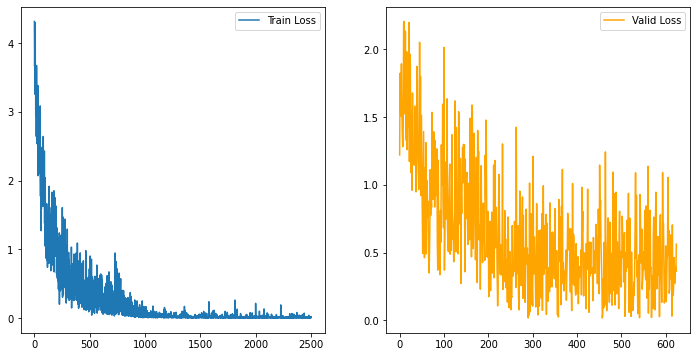

In [6]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])
